Compare the terrorist attack dataset graph with the Barabasi-Albert model.

In [12]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy

In [13]:
graphs          = np.load('graphs.npy')                  # the adjacency matrix
graphLO, graphL = graphs
n_nodes   = graphLO.number_of_nodes()                    # the number of nodes in the network
n_edgesLO = graphLO.number_of_edges()                    # the number of edges in the network Loc & Org
n_edgesL  = graphL.number_of_edges()                     # the number of edges in the network Loc

In [14]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    adjacency = np.zeros((n, n))
    
    random.seed(seed)
    p = float(p)
    for i in range(n):
        for j in range(i+1):
            x = random.uniform(0, 1)
            adjacency[i][j] = int(x<=p and i != j)
            adjacency[j][i] = adjacency[i][j]
    
    return adjacency

In [15]:
def barabasi_albert(n, m, m0=2, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int (optional)
        Number of nodes for the inital connected network.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    if m0<m:
        m0 = m
    # We begin with an Erdos-Renyi graph of arbitrary probability
    # and of size m0.
    p_0 = .5;
    initialAdjacency = erdos_renyi(m0,p_0,seed)
    adjacency = np.zeros((n,n))
    adjacency[0:m0, 0:m0] = initialAdjacency
    np.random.seed(seed)
    # Add a random link to every disconnected node
    if m0 > 1:
        for i in range(m0):
            if np.all(adjacency[i,:] == 0):
                # Found a disconnected node
                possibleNeighbors = list(range(m0))
                possibleNeighbors.remove(i)
                index = np.random.randint(low=0,high=m0-1)
                j = possibleNeighbors[index]
                adjacency[i,j] = 1
                adjacency[j,i] = 1

    # Grow the network according to the Barabasi-Albert model
    for newNodeId in range(m0, n):
        
        # Build the degree distribution of the network already built
        nLinks = np.sum(np.triu(adjacency))
        if nLinks > 0:
            degreeDistribution = np.sum(adjacency[0:newNodeId,0:newNodeId], axis=0)/2/nLinks
        else:
            degreeDistribution = np.array([1.])
        for addNewLink in range(m):
            connectToNode = np.random.choice(range(newNodeId),p=degreeDistribution)
            adjacency[connectToNode, newNodeId] = 1.
            adjacency[newNodeId, connectToNode] = 1.
    
    return adjacency

As explained in milestone 2, we can use the following approximation: $m \approx \frac{n_{\text{edges}}}{n_{\text{nodes}}}$.

In [35]:
barabasiAdjacencyLO = barabasi_albert(n_nodes, int(n_edgesLO/n_nodes)+1, 2, 9000) 
barabasiAdjacencyL  = barabasi_albert(n_nodes, int(n_edgesL/n_nodes)+1, 2, 9000) 

In [36]:
n_edges_barabasiLO = np.sum(np.triu(barabasiAdjacencyLO))
n_edges_barabasiL  = np.sum(np.triu(barabasiAdjacencyL))
print(n_edgesLO)
print(n_edges_barabasiLO)
print(n_edgesL)
print(n_edges_barabasiL)

3172
3140.0
571
644.0


In [37]:
barabasiLO = nx.from_numpy_matrix(barabasiAdjacencyLO)
barabasiL  = nx.from_numpy_matrix(barabasiAdjacencyL)

In [38]:
degreePerNodeBarabasiLO = np.sum(barabasiAdjacencyLO, axis = 0)
degreePerNodeBarabasiL  = np.sum(barabasiAdjacencyL,  axis = 0)
degreePerNodeLO         = np.sum(nx.adjacency_matrix(graphLO), axis = 0)
degreePerNodeL          = np.sum(nx.adjacency_matrix(graphL),  axis = 0)
ksLO = range(1,np.max(degreePerNodeLO))
ksL  = range(1,np.max(degreePerNodeL))

In [39]:
# log-scaled bins
binsLO = np.logspace(0, np.log10(np.max(degreePerNodeLO)), 
                     len(ksLO))
binsL  = np.logspace(0, np.log10(np.max(degreePerNodeL)) , 
                    len(ksL))
binsBarabasiLO = np.logspace(0, np.log10(np.max(degreePerNodeBarabasiLO)), 
                             len(ksLO))
binsBarabasiL  = np.logspace(0, np.log10(np.max(degreePerNodeBarabasiL)) , 
                             len(ksL))

# Calculate histogram
expDistribtionLO = np.histogram(degreePerNodeLO, bins=binsLO,density=True)
expDistribtionL  = np.histogram(degreePerNodeL   , bins=binsL ,density=True)
expDistribtionBarabasiLO = np.histogram(degreePerNodeBarabasiLO, bins=binsBarabasiLO,density=True)
expDistribtionBarabasiL  = np.histogram(degreePerNodeBarabasiL , bins=binsBarabasiL ,density=True)

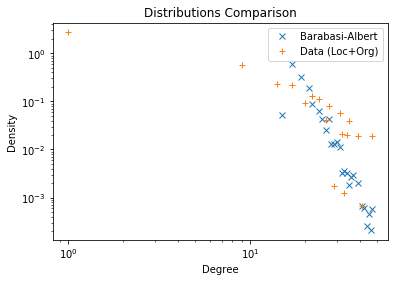

In [40]:
plt.loglog(ksLO[0:-1],expDistribtionBarabasiLO[0],'x')
plt.loglog(ksLO[0:-1], expDistribtionLO[0],'+')
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Distributions Comparison')
plt.legend(['Barabasi-Albert','Data (Loc+Org)'])
pass

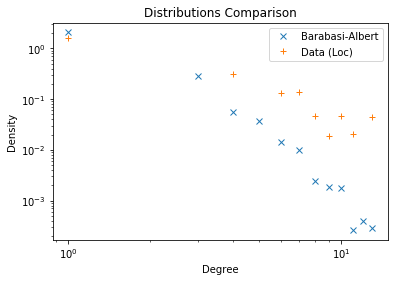

In [41]:
plt.loglog(ksL[0:-1], expDistribtionBarabasiL[0],'x')
plt.loglog(ksL[0:-1], expDistribtionL[0],'+')
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Distributions Comparison')
plt.legend(['Barabasi-Albert','Data (Loc)'])
pass